### Simple COVID-19 stochastic model based on Anderson et al. (_Lancet 2020_)

Below I define a stochastic version of the model defined diagrammatically below taken from Anderson et al. (_Lancet 2020_), linked here: https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30567-5/fulltext.

<img src="diagram-from-Anderson2020.png" width="600"/>

Note that in the epidemology of an SEIR model, the formalism usually indicates that, in this case, $\lambda = \beta  (I_1+I^{\rm mild}_2+I^{\rm mild}_3+bI^{\rm severe}_2+bI^{\rm severe}_3 + mY_2 + mY_3 + gE)/N_{\rm tot}$. First the following imports are necessary...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Then the model parameters (all in units of 1/day) and initial compartment numbers must be defined (these have been taken from SI3 of the Anderson et al. article here: https://www.thelancet.com/cms/10.1016/S0140-6736(20)30567-5/attachment/bcade790-6075-4a41-8fbd-f65e77d727bf/mmc3.pdf)...

In [2]:
b, bet, m, g, sig, gam1, gam2, gam3, alph, p = 1.0, 0.11, 1.0, 0.0, 1.0/2.42, 1.0/2.42, 1.0/10.0, 1.0/10.0, 0.0, 0.5
S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R = 9995, 5, 0, 0, 0, 0, 0, 0, 0, 0

Finally, the number of realisations and the number of days to run must be chosen...

In [3]:
nreals = 100
ndays = 250

The model is coded in the following function...

In [4]:
# Package parameters and initial conditions all together
params = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p]
initconds = [S*np.ones(nreals),E*np.ones(nreals), I1*np.ones(nreals), I2mild*np.ones(nreals),\
             I2severe*np.ones(nreals), I3mild*np.ones(nreals), I3severe*np.ones(nreals), Y2*np.ones(nreals),\
             Y3*np.ones(nreals), R*np.ones(nreals)]
# Define model function to output after specified time period
def covid_simple(initconds,params,reals,runtime,output_to_file): 
    # Open storage for output to file
    f = open(output_to_file, "w")
    # Unpack parameters and initial conditions
    [b, bet, m, g, sig, gam1, gam2, gam3, alph, p] = params
    [S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R] = initconds 
    # Convert to float because I'm like that...
    runtime = float(runtime)   
    # Compute total population number for each realisation
    Ntot = S+E+I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3+R
    # Main loop
    t = np.zeros(reals)
    terminated = np.ones(reals)
    while np.any(t < runtime):
        # Terminate loop if everyone has recovered
        if np.all(S+E+I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3) == 0: break
        # Update the event rates
        rate_S_E = bet*(I1+I2mild+b*I2severe+I3mild+b*I3severe+m*Y2+m*Y3+g*E)*S/Ntot 
        rate_E_I1, rate_I1_I2, rate_I2severe_Y2 = sig*E, gam1*I1, alph*I2severe
        rate_I2mild_I3mild, rate_I2severe_I3severe, rate_Y2_Y3 = gam2*I2mild, gam2*I2severe, gam2*Y2
        rate_I3mild_R, rate_I3severe_R, rate_Y3_R = gam3*I3mild, gam3*I3severe, gam3*Y3       
        # Sum the rates
        rate_sum = rate_S_E + rate_E_I1 + rate_I1_I2 + rate_I2severe_Y2 + rate_I2mild_I3mild + \
                   rate_I2severe_I3severe + rate_Y2_Y3 + rate_I3mild_R + rate_I3severe_R + rate_Y3_R
        # Avoid pathologies at the end
        rate_sum[rate_sum<=0.0] = 1.0
        # Take step forward in time and determine when to stop each run
        t = t + terminated*np.random.exponential(1.0/rate_sum,size=reals) 
        terminated = (t<runtime)
        # Choose the event to occur in each realisation
        severe = np.random.binomial(1,p,size=reals)
        event = np.random.uniform(size=reals)
        event_probs = np.asarray([rate_S_E/rate_sum,rate_E_I1/rate_sum,\
                                  rate_I1_I2/rate_sum,rate_I2severe_Y2/rate_sum,rate_I2mild_I3mild/rate_sum,\
                                  rate_I2severe_I3severe/rate_sum,rate_Y2_Y3/rate_sum,rate_I3mild_R/rate_sum,\
                                  rate_I3severe_R/rate_sum,rate_Y3_R/rate_sum])
        cumul_probs = np.cumsum(event_probs,axis=0)
        # S -> E
        S = S - terminated*(event<cumul_probs[0])
        # S -> E, E -> I1
        E = E + terminated*(event<cumul_probs[0]) - terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0])
        # E -> I1, I1 -> I2
        I1 = I1 + terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0]) \
                - terminated*(cumul_probs[2]>event)*(event>=cumul_probs[1])
        # I1 -> I2mild, I2mild -> I3mild
        I2mild = I2mild + terminated*(severe==0)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                        - terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3])
        # I1 -> I2severe, I2severe -> Y2, I2severe -> I3severe
        I2severe = I2severe + terminated*(severe==1)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                            - terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                            - terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4])
        # I2mild -> I3mild, I3mild -> R
        I3mild = I3mild + terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3]) \
                        - terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6])
        # I2severe -> I3severe, I3severe -> R
        I3severe = I3severe + terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4]) \
                            - terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7])
        # I2severe -> Y2, Y2 -> Y3
        Y2 = Y2 + terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                - terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5])
        # Y2 -> Y3, Y3 -> R
        Y3 = Y3 + terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5]) \
                - terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # I3mild -> R, I3severe -> R, Y3 -> R
        R = R + terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6]) \
              + terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7]) \
              + terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # Store values in file
        f.write(','.join(map(str,np.concatenate([t, S, E, I1, I2mild, I2severe, \
                                                 I3mild, I3severe, Y2, Y3, R]).ravel().tolist()))+'\n')
        f.flush()
    # Close file
    f.close()
    # Setup output column name list
    column_names = []
    for l in ['t', 'S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R']:
        for r in range(0,nreals):
            column_names.append(l+'_'+str(r))
    # Load dataframe with column names
    df = pd.read_csv(output_to_file,names=column_names)
    # Create dictionary of sub dataframes from output for each time series realisation
    dict_of_dfs = {}
    for r in range(0,nreals):
        dict_of_dfs['real_'+str(r)] = df[['t_'+str(r), 'S_'+str(r), 'E_'+str(r), 'Ii_'+str(r),\
                                          'Iiimild_'+str(r), 'Iiisevere_'+str(r), 'Iiiimild_'+str(r),\
                                          'Iiiisevere_'+str(r), 'Yii_'+str(r), 'Yiii_'+str(r), 'R_'+str(r)]]
        # Strip the time column of its number for merging
        dict_of_dfs['real_'+str(r)].columns = dict_of_dfs['real_'+str(r)].columns.str.rstrip('_'+str(r))
    # Output resulting compartment numbers to a dictionary of pandas dataframes
    return dict_of_dfs

Let's run the code and create a time-merged dataframe with all of the realisations and compartments as columns...

In [5]:
# Run code and obtain dictionary of dataframes output
ddf = covid_simple(initconds,params,nreals,ndays,'test.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df = ddf['real_0']
merged_df.columns = merged_df.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf['real_'+str(r)].columns = ddf['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df = pd.merge_asof(merged_df,ddf['real_'+str(r)],on='t')
# Set index to time
merged_df = merged_df.set_index('t')
merged_df

,S_0,E_0,Ii_0,Iiimild_0,Iiisevere_0,Iiiimild_0,Iiiisevere_0,Yii_0,Yiii_0,R_0,...,S_99,E_99,Ii_99,Iiimild_99,Iiisevere_99,Iiiimild_99,Iiiisevere_99,Yii_99,Yiii_99,R_99
t,,,,,,,,,,,,,,,,,,,,,
0.019179,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.311599,9995.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.319230,9995.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.482013,9995.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.601690,9995.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250.741738,1150.0,0.0,1.0,6.0,1.0,17.0,10.0,0.0,0.0,8815.0,...,1106.0,0.0,0.0,1.0,1.0,4.0,3.0,0.0,0.0,8885.0
250.741738,1150.0,0.0,1.0,6.0,1.0,17.0,10.0,0.0,0.0,8815.0,...,1106.0,0.0,0.0,1.0,1.0,4.0,3.0,0.0,0.0,8885.0
250.741738,1150.0,0.0,1.0,6.0,1.0,17.0,10.0,0.0,0.0,8815.0,...,1106.0,0.0,0.0,1.0,1.0,4.0,3.0,0.0,0.0,8885.0


Let's first plot the mean and 95% credible region for each compartment...

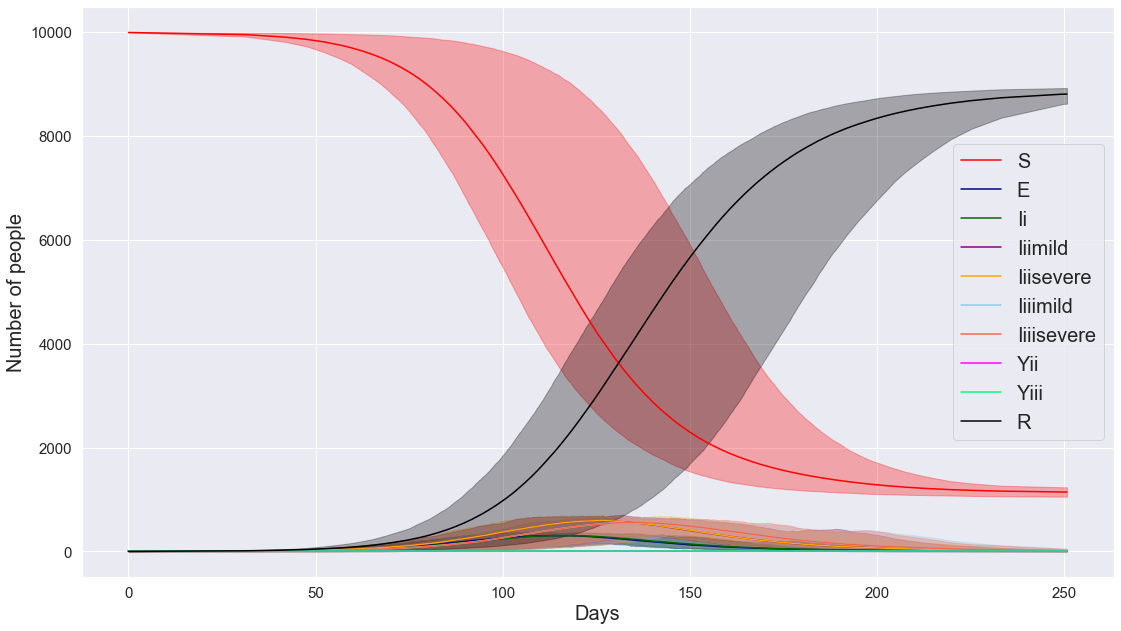

In [6]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Loop over all compartments of the model and plot on the same axes
for lab, col in zip(['S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R'],
       ['red','darkblue','darkgreen','purple','orange','skyblue','tomato','magenta','springgreen','black']):
    # Compute mean and credible limits
    df = merged_df[[lab+'_'+str(r) for r in range(0,nreals)]]
    df_mean = df.iloc[::plot_every_n, :].mean(axis=1)
    df_lowerCL = df.iloc[::plot_every_n, :].quantile(0.025,axis=1)
    df_upperCL = df.iloc[::plot_every_n, :].quantile(0.975,axis=1)
    # Plot the mean and credible limits in each case
    plt.plot(merged_df.index[::plot_every_n],df_mean.values,color=col,label=lab)
    plt.fill_between(merged_df.index[::plot_every_n],df_lowerCL.values,df_upperCL.values,color=col,alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_ylabel('Number of people',fontsize=20)
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

### Plotting the effective reproduction number and epidemic growth rate

We need to do a little bit of linear algebra to compute the basic reproduction number $R_0$ of the system. At the disease-free equilibrium, $S=N_{\rm tot}$ and all other compartments vanish, hence, using the vector space of infected compartments $(E,I_1,I_2^{\rm mild},I_2^{\rm severe},I_3^{\rm mild},I_3^{\rm severe},Y_2,Y_3)^{\rm T}$, the next-generation matrix (see here: https://en.wikipedia.org/wiki/Next-generation_matrix) for the above model is pretty trivial

$$F=(\lambda S,0,0,0,0,0,0,0)^{\rm T}$$

$$V=[\sigma E,\gamma_1I_1-\sigma E,\gamma_2 I^{\rm mild}_2-\gamma_1(1-p)I_1,(\gamma_2+\alpha )I^{\rm severe}_2-\gamma_1pI_1,\gamma_3I_3^{\rm mild}-\gamma_2I^{\rm mild}_2,\gamma_3I^{\rm severe}_3-\gamma_2I_2^{\rm severe},\gamma_2Y_2-\alpha I^{\rm severe}_2,\gamma_3Y_3-\gamma_2Y_2]^{\rm T}$$

$${\cal J}(F) = \begin{pmatrix} \beta g & \beta & \beta & \beta b  & \beta  & \beta b & \beta m &  \beta m \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{pmatrix}$$ 

$${\cal J}(V) = \begin{pmatrix} \sigma  & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ -\sigma & \gamma_1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & -\gamma_1(1-p) & \gamma_2 & 0 & 0 & 0 & 0 & 0 \\ 0 & -\gamma_1p & 0 & \gamma_2+\alpha & 0 & 0 & 0 & 0 \\ 0 & 0 & -\gamma_2 & 0 & \gamma_3 & 0 & 0 & 0 \\ 0 & 0 & 0 & -\gamma_2 & 0 & \gamma_3 & 0 & 0 \\ 0 & 0 & 0 & -\alpha & 0 & 0 & \gamma_2 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -\gamma_2 & \gamma_3 \end{pmatrix}$$

$$\Longrightarrow {\rm NGM} =  {\cal J}(F){\cal J}(V)^{-1} \Longrightarrow \rho ({\rm NGM}) = R_0 = \frac{\beta g}{\sigma} + \frac{\beta}{\gamma_1} + \frac{\beta (1-p)}{\gamma_2} + \frac{\beta b p}{\alpha + \gamma_2} + \frac{\beta (1-p)}{\gamma_3} + \frac{\beta b \gamma_2p}{(\alpha + \gamma_2)\gamma_3} + \frac{\beta m \alpha p}{(\alpha + \gamma_2)\gamma_2} + \frac{\beta m \alpha p}{(\alpha + \gamma_2)\gamma_3}\,,$$

where $\rho (\cdot )$ just denotes the spectral radius. The effective reproduction number $R_t$ at time $t$ in this model is simply $R_t = R_0 (S/N_{\rm tot})$ and the epidemic growth rate $r_t$ is numerically calculable from $r_t = \delta \ln (I_1+I^{\rm mild}_2+I^{\rm severe}_2+I^{\rm mild}_3+I^{\rm severe}_3+Y_2+Y_3) / \delta t$, hence, the output data can also be plotted to give these values...

/Users/Ben/opt/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:1067: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/Ben/opt/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:1068: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/Ben/opt/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:1068: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/Ben/opt/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:1069: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/Ben/opt/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:1069: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/Ben/opt/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/lib

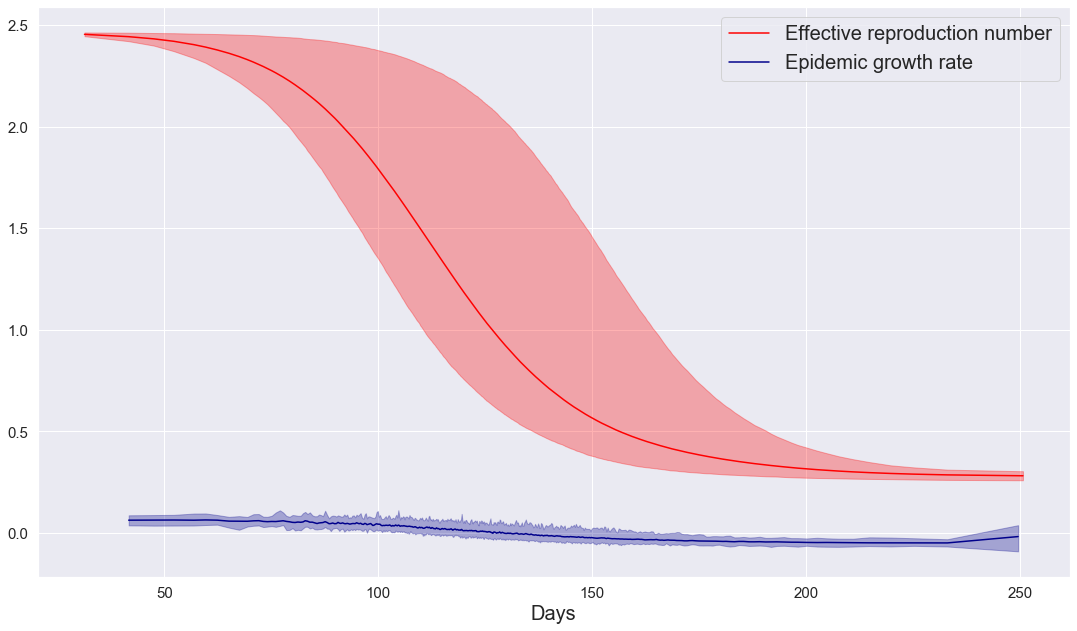

In [7]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Order of centred finite difference used to compute the epidemic growth rate (can be 1 or 2)
order_grad = 2
# Pull out values from merged dataframe
S_df = merged_df[['S_'+str(r) for r in range(0,nreals)]]
E_df = merged_df[['E_'+str(r) for r in range(0,nreals)]]
Ii_df = merged_df[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df = merged_df[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df = merged_df[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df = merged_df[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df = merged_df[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df = merged_df[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df = merged_df[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df = merged_df[['R_'+str(r) for r in range(0,nreals)]]
# Compute the total infected, the basic and effective reproduction numbers and epidemic growth rate
times = Ii_df.iloc[::plot_every_n, :].index
totpop = S_df.iloc[0,0]+E_df.iloc[0,0]+Ii_df.iloc[0,0]+Iiimild_df.iloc[0,0]+Iiisevere_df.iloc[0,0]+\
         Iiiimild_df.iloc[0,0]+Iiiisevere_df.iloc[0,0]+Yii_df.iloc[0,0]+Yiii_df.iloc[0,0]+R_df.iloc[0,0]
totinf = Ii_df.iloc[::plot_every_n, :].values+Iiimild_df.iloc[::plot_every_n, :].values+\
         Iiisevere_df.iloc[::plot_every_n, :].values+Iiiimild_df.iloc[::plot_every_n, :].values+\
         Iiiisevere_df.iloc[::plot_every_n, :].values+Yii_df.iloc[::plot_every_n, :].values+\
         Yiii_df.iloc[::plot_every_n, :].values
brn = (bet*g/sig) + (bet/gam1) + (bet*(1.0-p)/gam2) + (bet*b*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
      (bet*b*gam2*p/(gam3*(alph+gam2))) + (bet*m*alph*p/(gam2*(alph+gam2))) + (bet*m*alph*p/(gam3*(alph+gam2)))
ern = brn*(S_df.iloc[::plot_every_n, :].values/totpop)
egr = np.gradient(np.log(totinf),times,axis=0,edge_order=order_grad)
# Compute mean and credible limits of the effective reproduction number and epidemic growth rate  
ern_mean = np.mean(ern,axis=1)
ern_lowerCL = np.quantile(ern,0.025,axis=1)
ern_upperCL = np.quantile(ern,0.975,axis=1)
egr_mean = np.mean(egr,axis=1)
egr_lowerCL = np.quantile(egr,0.025,axis=1)
egr_upperCL = np.quantile(egr,0.975,axis=1)
# Plot the mean and credible limits in each case
plt.plot(times,ern_mean,color='red',label='Effective reproduction number')
plt.fill_between(times,ern_lowerCL,ern_upperCL,color='red',alpha=0.3)
plt.plot(times,egr_mean,color='darkblue',label='Epidemic growth rate')
plt.fill_between(times,egr_lowerCL,egr_upperCL,color='darkblue',alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

### Using the simulation to mimic lockdown after a specified number of days

By running two successive simulations we can also mimic the lockdown ($\alpha > 0$ and $b < 1$) after a specified number of days...

In [8]:
# Number of days to run pre-lockdown
ndays_to_lockdown = 90
# Number of day to run post-lockdown
ndays_beyond_lockdown = 160
# Pre-lockdown parameters and initial conditions
b, bet, m, g, sig, gam1, gam2, gam3, alph, p = 1.0, 0.11, 1.0, 0.0, 1.0/2.42, 1.0/2.42, 1.0/10.0, 1.0/10.0, 0.0, 0.5
S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R = 9995, 5, 0, 0, 0, 0, 0, 0, 0, 0
# Package parameters and initial conditions all together
params_pre = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p]
initconds_pre = [S*np.ones(nreals),E*np.ones(nreals), I1*np.ones(nreals), I2mild*np.ones(nreals),\
                 I2severe*np.ones(nreals), I3mild*np.ones(nreals), I3severe*np.ones(nreals), Y2*np.ones(nreals),\
                 Y3*np.ones(nreals), R*np.ones(nreals)]
# Run pre-lockdown pandemic
ddf_pre = covid_simple(initconds_pre,params_pre,nreals,ndays_to_lockdown,'test.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_pre = ddf_pre['real_0']
merged_df_pre.columns = merged_df_pre.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_pre['real_'+str(r)].columns = ddf_pre['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_pre = pd.merge_asof(merged_df_pre,ddf_pre['real_'+str(r)],on='t')
# Set index to time
merged_df_pre = merged_df_pre.set_index('t')
# Pull out values from merged pre-lockdown dataframe
S_df_pre = merged_df_pre[['S_'+str(r) for r in range(0,nreals)]]
E_df_pre = merged_df_pre[['E_'+str(r) for r in range(0,nreals)]]
Ii_df_pre = merged_df_pre[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df_pre = merged_df_pre[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df_pre = merged_df_pre[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df_pre = merged_df_pre[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df_pre = merged_df_pre[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df_pre = merged_df_pre[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df_pre = merged_df_pre[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df_pre = merged_df_pre[['R_'+str(r) for r in range(0,nreals)]]
# Update the parameters and initial conditions for the post-lockdown runs
b, bet, m, g, sig, gam1, gam2, gam3, alph, p = 0.8,0.11,0.01,0.0,1.0/2.42, 1.0/2.42, 1.0/10.0, 1.0/10.0, 1.0/5.14, 0.5
params_post = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p]
initconds_post = [S_df_pre.values[-1],E_df_pre.values[-1], Ii_df_pre.values[-1], Iiimild_df_pre.values[-1],\
                  Iiisevere_df_pre.values[-1], Iiiimild_df_pre.values[-1], Iiiisevere_df_pre.values[-1],\
                  Yii_df_pre.values[-1],Yiii_df_pre.values[-1], R_df_pre.values[-1]]
# Run post-lockdown pandemic
ddf_post = covid_simple(initconds_post,params_post,nreals,ndays_beyond_lockdown,'test.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_post = ddf_post['real_0']
merged_df_post.columns = merged_df_post.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_post['real_'+str(r)].columns = ddf_post['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_post = pd.merge_asof(merged_df_post,ddf_post['real_'+str(r)],on='t')
# Set index to time
merged_df_post = merged_df_post.set_index('t')
# Add days pre-lockdown to total time 
merged_df_post.index = merged_df_post.index + ndays_to_lockdown
# Append the post-lockdown dataframe to the pre-lockdown dataframe
merged_df = merged_df_pre.append(merged_df_post)

Let's plot the compartments again to see how the system evolves over the total length of time...

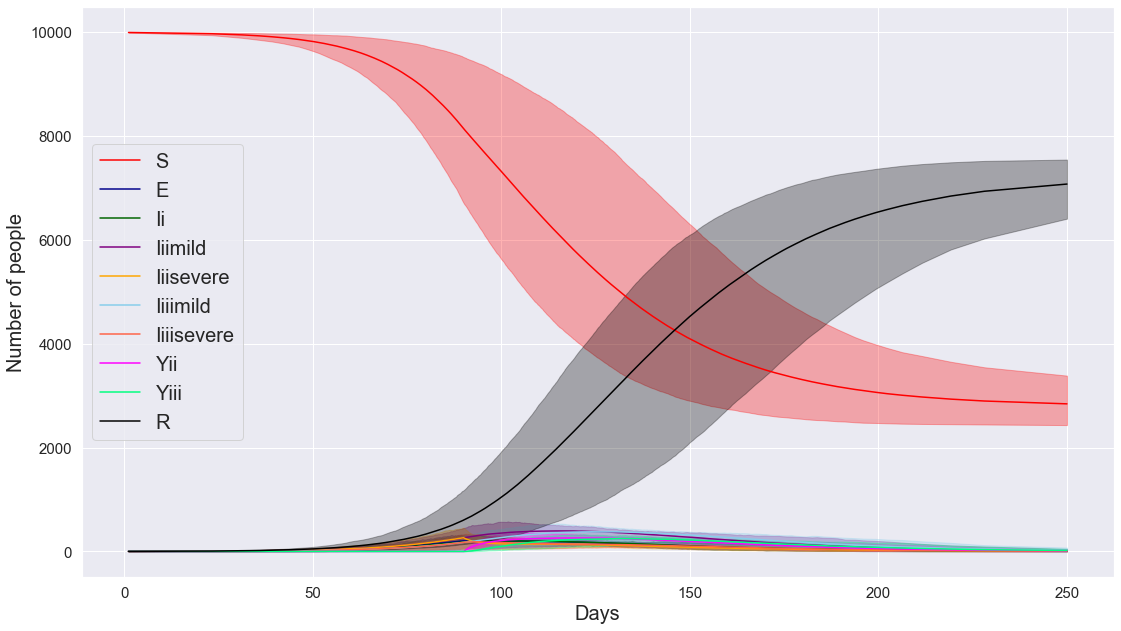

In [9]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Loop over all compartments of the model and plot on the same axes
for lab, col in zip(['S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R'],
       ['red','darkblue','darkgreen','purple','orange','skyblue','tomato','magenta','springgreen','black']):
    # Compute mean and credible limits
    df = merged_df[[lab+'_'+str(r) for r in range(0,nreals)]]
    df_mean = df.iloc[::plot_every_n, :].mean(axis=1)
    df_lowerCL = df.iloc[::plot_every_n, :].quantile(0.025,axis=1)
    df_upperCL = df.iloc[::plot_every_n, :].quantile(0.975,axis=1)
    # Plot the mean and credible limits in each case
    plt.plot(merged_df.index[::plot_every_n],df_mean.values,color=col,label=lab)
    plt.fill_between(merged_df.index[::plot_every_n],df_lowerCL.values,df_upperCL.values,color=col,alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_ylabel('Number of people',fontsize=20)
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

And let's look at the corresponding effective reproduction number and epidemic growth rate...

/Users/Ben/opt/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:1067: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))


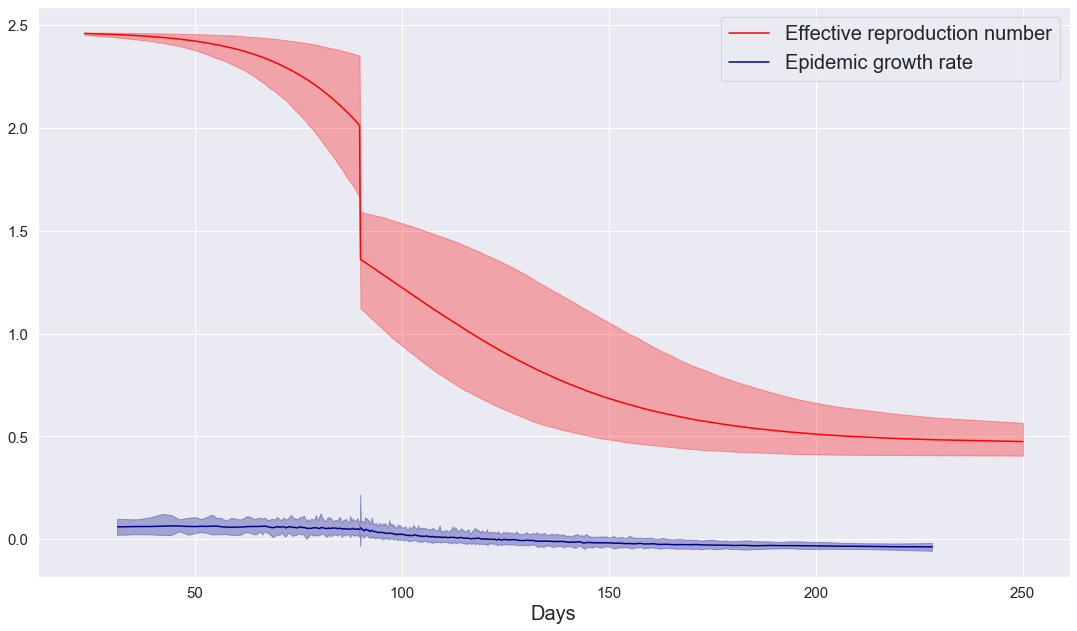

In [10]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Order of centred finite difference used to compute the epidemic growth rate (can be 1 or 2)
order_grad = 2
# Pull out values from merged dataframe
S_df = merged_df[['S_'+str(r) for r in range(0,nreals)]]
E_df = merged_df[['E_'+str(r) for r in range(0,nreals)]]
Ii_df = merged_df[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df = merged_df[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df = merged_df[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df = merged_df[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df = merged_df[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df = merged_df[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df = merged_df[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df = merged_df[['R_'+str(r) for r in range(0,nreals)]]
# Compute the total infected, the basic and effective reproduction numbers and epidemic growth rate
times = Ii_df.iloc[::plot_every_n, :].index
totpop = S_df.iloc[0,0]+E_df.iloc[0,0]+Ii_df.iloc[0,0]+Iiimild_df.iloc[0,0]+Iiisevere_df.iloc[0,0]+\
         Iiiimild_df.iloc[0,0]+Iiiisevere_df.iloc[0,0]+Yii_df.iloc[0,0]+Yiii_df.iloc[0,0]+R_df.iloc[0,0]
totinf = Ii_df.iloc[::plot_every_n, :].values+Iiimild_df.iloc[::plot_every_n, :].values+\
         Iiisevere_df.iloc[::plot_every_n, :].values+Iiiimild_df.iloc[::plot_every_n, :].values+\
         Iiiisevere_df.iloc[::plot_every_n, :].values+Yii_df.iloc[::plot_every_n, :].values+\
         Yiii_df.iloc[::plot_every_n, :].values
[b, bet, m, g, sig, gam1, gam2, gam3, alph, p] = params_pre
brn_pre = (bet*g/sig) + (bet/gam1) + (bet*(1.0-p)/gam2) + (bet*b*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
          (bet*b*gam2*p/(gam3*(alph+gam2))) + (bet*m*alph*p/(gam2*(alph+gam2))) + (bet*m*alph*p/(gam3*(alph+gam2)))
[b, bet, m, g, sig, gam1, gam2, gam3, alph, p] = params_post
brn_post = (bet*g/sig) + (bet/gam1) + (bet*(1.0-p)/gam2) + (bet*b*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
          (bet*b*gam2*p/(gam3*(alph+gam2))) + (bet*m*alph*p/(gam2*(alph+gam2))) + (bet*m*alph*p/(gam3*(alph+gam2)))
ern = brn_pre*(S_df.iloc[::plot_every_n, :].values/totpop)*\
              (np.tensordot(times,np.ones(nreals),axes=0)<ndays_to_lockdown) + \
      brn_post*(S_df.iloc[::plot_every_n, :].values/totpop)*\
              (np.tensordot(times,np.ones(nreals),axes=0)>=ndays_to_lockdown)
egr = np.gradient(np.log(totinf),times,axis=0,edge_order=order_grad)
# Compute mean and credible limits of the effective reproduction number and epidemic growth rate  
ern_mean = np.mean(ern,axis=1)
ern_lowerCL = np.quantile(ern,0.025,axis=1)
ern_upperCL = np.quantile(ern,0.975,axis=1)
egr_mean = np.mean(egr,axis=1)
egr_lowerCL = np.quantile(egr,0.025,axis=1)
egr_upperCL = np.quantile(egr,0.975,axis=1)
# Plot the mean and credible limits in each case
plt.plot(times,ern_mean,color='red',label='Effective reproduction number')
plt.fill_between(times,ern_lowerCL,ern_upperCL,color='red',alpha=0.3)
plt.plot(times,egr_mean,color='darkblue',label='Epidemic growth rate')
plt.fill_between(times,egr_lowerCL,egr_upperCL,color='darkblue',alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

### Possible modification to include heterogeneity in the number of secondary infections without an IBM (thanks to Ben Collyer for insights and code development in this section)

Heterogeneity in the number of secondary infections generated from a single initial infection can clearly be encoded by an individual-based model where an appropriate (e.g., Gamma or Wishart) distribution can be placed on the spreading capacity of an individual to recruit more infections from susceptible $S$ to the incubating class $E$. In the spirit of this notebook keeping the model as simple as possible, we are going to modify the code as it is with a compound Poisson process to achieve the same goal. If the distribution over the number of secondary infections given an initial infection were a negative binomial (it isn't, but just go with it), then we expect the mean to be $\lambda T$, where $\lambda = \beta  (I_1+I^{\rm mild}_2+I^{\rm mild}_3+bI^{\rm severe}_2+bI^{\rm severe}_3 + mY_2 + mY_3 + gE)/N_{\rm tot}$ and $T$ is the mean time of infection (which could potentially be roughly estimated as $R_0/\beta$). One possible way to generate this heterogeneous distribution would be to draw the number of $S\rightarrow E$ transitions from a compound Poisson process with logseries amplitude. In this process, the number of people to have moved from $S\rightarrow E$ is

$$N_{S\rightarrow E}=\sum^{n}_{i=1}x_i\,, \quad n\sim {\rm Poisson}\bigg[ n;N_{\rm inf}k\ln \bigg( 1+\frac{\lambda T}{N_{\rm inf}k}\bigg) \bigg]\,, \quad x_i \sim {\rm LogSeries}\bigg[ x_i; \bigg(1+\frac{N_{\rm inf}k}{\lambda T}\bigg)^{-1}\bigg] \,.$$

To demonstrate that $N_{S\rightarrow E}$ follows a negative binomial distribution, one notes that its probability generating function $\varphi_{N_{S\rightarrow E}}(z)$ must be

$\varphi_{N_{S\rightarrow E}}(z) = \exp \bigg\{ N_{\rm inf}k\ln \bigg( 1+\frac{\lambda T}{N_{\rm inf}k}\bigg) \big[ \varphi_{x_i}(z) - 1\big]\bigg\} $

$\qquad \qquad = \exp \bigg( N_{\rm inf}k\bigg\{ \ln \bigg[ \frac{N_{\rm inf}k+\lambda T}{N_{\rm inf}k+(1-z)\lambda T}\bigg] - \ln \big( N_{\rm inf}k + \lambda T \big) +\ln N_{\rm inf}k \bigg\} \bigg) $

$\qquad \qquad = \bigg[ 1+ (1-z)\frac{\lambda T}{N_{\rm inf}k}\bigg]^{-N_{\rm inf}k}\,.$

This is the probability generating function of a negative binomial with mean $\lambda T$ and the sum of $N_{\rm inf}=I_1+I^{\rm mild}_2+I^{\rm severe}_2+I^{\rm mild}_3+I^{\rm severe}_3+Y_2+Y_3+E$ aggregations, $N_{\rm inf}k$. Hence, to obtain a negative binomial distribution over the number of secondary infections in the simulation, we iteratively update $\lambda$ according to the numbers of infectives and use this value to compute a rate for the $S\rightarrow E$ transition for $N_{\rm inf}$ infectives interacting with the population. The resulting simulation is...

In [15]:
# Added the aggregation parameter k here
b, bet, m, g,sig,gam1,gam2,gam3,alph,p,k = 1.0, 0.11, 1.0, 0.0, 1.0/2.42, 1.0/2.42, 1.0/10.0, 1.0/10.0, 0.0, 0.5, 0.1
S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R = 9995, 5, 0, 0, 0, 0, 0, 0, 0, 0
nreals = 100
ndays = 250
# Package parameters and initial conditions all together
params = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, k]
initconds = [S*np.ones(nreals),E*np.ones(nreals), I1*np.ones(nreals), I2mild*np.ones(nreals),\
             I2severe*np.ones(nreals), I3mild*np.ones(nreals), I3severe*np.ones(nreals), Y2*np.ones(nreals),\
             Y3*np.ones(nreals), R*np.ones(nreals)]
# Define model function to output after specified time period
def covid_simple_het(initconds,params,reals,runtime,output_to_file): 
    # Open storage for output to file
    f = open(output_to_file, "w")
    # Unpack parameters and initial conditions
    [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, k] = params
    [S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R] = initconds 
    # Convert to float because I'm like that...
    runtime = float(runtime)   
    # Compute total population number for each realisation
    Ntot = S+E+I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3+R
    # Compute the basic reproduction number and the average infectious time prior to the simulation loop
    brn = (bet*g/sig) + (bet/gam1) + (bet*(1.0-p)/gam2) + (bet*b*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
          (bet*b*gam2*p/(gam3*(alph+gam2))) + (bet*m*alph*p/(gam2*(alph+gam2))) + (bet*m*alph*p/(gam3*(alph+gam2)))
    T = 20.0 # brn/bet 
    # Main loop
    t = np.zeros(reals)
    terminated = np.ones(reals)
    while np.any(t < runtime):
        # Terminate loop if everyone has recovered
        if np.all(S+E+I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3) == 0: break            
        # Update the event rates
        old_rate_S_E = bet*(I1+I2mild+b*I2severe+I3mild+b*I3severe+m*Y2+m*Y3+g*E)*S/Ntot
        N_inf = I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3+E
        # Note the new rate_S_E divides by T for dimensions. Note that k=0 causes issues so np.maximum is used
        kN = k*np.maximum(1,N_inf)
        rate_S_E = kN*np.log(1.0+(old_rate_S_E*T/kN))/T 
        rate_E_I1, rate_I1_I2, rate_I2severe_Y2 = sig*E, gam1*I1, alph*I2severe
        rate_I2mild_I3mild, rate_I2severe_I3severe, rate_Y2_Y3 = gam2*I2mild, gam2*I2severe, gam2*Y2
        rate_I3mild_R, rate_I3severe_R, rate_Y3_R = gam3*I3mild, gam3*I3severe, gam3*Y3       
        # Sum the rates
        rate_sum = rate_S_E + rate_E_I1 + rate_I1_I2 + rate_I2severe_Y2 + rate_I2mild_I3mild + \
                   rate_I2severe_I3severe + rate_Y2_Y3 + rate_I3mild_R + rate_I3severe_R + rate_Y3_R
        # Avoid pathologies at the end
        rate_sum[rate_sum<=0.0] = 1.0
        # Take step forward in time and determine when to stop each run
        t = t + terminated*np.random.exponential(1.0/rate_sum,size=reals) 
        terminated = (t<runtime)
        # Choose the event to occur in each realisation
        severe = np.random.binomial(1,p,size=reals)
        event = np.random.uniform(size=reals)
        event_probs = np.asarray([rate_S_E/rate_sum,rate_E_I1/rate_sum,\
                                  rate_I1_I2/rate_sum,rate_I2severe_Y2/rate_sum,rate_I2mild_I3mild/rate_sum,\
                                  rate_I2severe_I3severe/rate_sum,rate_Y2_Y3/rate_sum,rate_I3mild_R/rate_sum,\
                                  rate_I3severe_R/rate_sum,rate_Y3_R/rate_sum])
        cumul_probs = np.cumsum(event_probs,axis=0)
        # Draw logseries S -> E event transition numbers for each realisation
        num_S_E = np.random.logseries((1.0+(kN/(old_rate_S_E*T)))**(-1.0),size=reals)
        # Make sure these don't exceed the actual number of susceptibles
        num_S_E = S*(num_S_E>S) + num_S_E*(num_S_E<=S)
        # S -> E (note new event number)
        S = S - terminated*(event<cumul_probs[0])*num_S_E
        # S -> E, E -> I1 (note new event number)
        E = E + terminated*(event<cumul_probs[0])*num_S_E - terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0])
        # E -> I1, I1 -> I2
        I1 = I1 + terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0]) \
                - terminated*(cumul_probs[2]>event)*(event>=cumul_probs[1])
        # I1 -> I2mild, I2mild -> I3mild
        I2mild = I2mild + terminated*(severe==0)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                        - terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3])
        # I1 -> I2severe, I2severe -> Y2, I2severe -> I3severe
        I2severe = I2severe + terminated*(severe==1)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                            - terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                            - terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4])
        # I2mild -> I3mild, I3mild -> R
        I3mild = I3mild + terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3]) \
                        - terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6])
        # I2severe -> I3severe, I3severe -> R
        I3severe = I3severe + terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4]) \
                            - terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7])
        # I2severe -> Y2, Y2 -> Y3
        Y2 = Y2 + terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                - terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5])
        # Y2 -> Y3, Y3 -> R
        Y3 = Y3 + terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5]) \
                - terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # I3mild -> R, I3severe -> R, Y3 -> R
        R = R + terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6]) \
              + terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7]) \
              + terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # Store values in file
        f.write(','.join(map(str,np.concatenate([t, S, E, I1, I2mild, I2severe, \
                                                 I3mild, I3severe, Y2, Y3, R]).ravel().tolist()))+'\n')
        f.flush()
    # Close file
    f.close()
    # Setup output column name list
    column_names = []
    for l in ['t', 'S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R']:
        for r in range(0,nreals):
            column_names.append(l+'_'+str(r))
    # Load dataframe with column names
    df = pd.read_csv(output_to_file,names=column_names)
    # Create dictionary of sub dataframes from output for each time series realisation
    dict_of_dfs = {}
    for r in range(0,nreals):
        dict_of_dfs['real_'+str(r)] = df[['t_'+str(r), 'S_'+str(r), 'E_'+str(r), 'Ii_'+str(r),\
                                          'Iiimild_'+str(r), 'Iiisevere_'+str(r), 'Iiiimild_'+str(r),\
                                          'Iiiisevere_'+str(r), 'Yii_'+str(r), 'Yiii_'+str(r), 'R_'+str(r)]]
        # Strip the time column of its number for merging
        dict_of_dfs['real_'+str(r)].columns = dict_of_dfs['real_'+str(r)].columns.str.rstrip('_'+str(r))
    # Output resulting compartment numbers to a dictionary of pandas dataframes
    return dict_of_dfs

In [16]:
# Run code and obtain dictionary of dataframes output
ddf = covid_simple_het(initconds,params,nreals,ndays,'test.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df = ddf['real_0']
merged_df.columns = merged_df.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf['real_'+str(r)].columns = ddf['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df = pd.merge_asof(merged_df,ddf['real_'+str(r)],on='t')
# Set index to time
merged_df = merged_df.set_index('t')
merged_df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide


,S_0,E_0,Ii_0,Iiimild_0,Iiisevere_0,Iiiimild_0,Iiiisevere_0,Yii_0,Yiii_0,R_0,...,S_99,E_99,Ii_99,Iiimild_99,Iiisevere_99,Iiiimild_99,Iiiisevere_99,Yii_99,Yiii_99,R_99
t,,,,,,,,,,,,,,,,,,,,,
0.154100,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.475057,9995.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.455413,9995.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.665536,9995.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.077309,9995.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251.201685,1220.0,0.0,0.0,1.0,0.0,5.0,1.0,0.0,0.0,8773.0,...,2090.0,136.0,161.0,390.0,411.0,479.0,452.0,0.0,0.0,5881.0
251.201685,1220.0,0.0,0.0,1.0,0.0,5.0,1.0,0.0,0.0,8773.0,...,2090.0,136.0,161.0,390.0,411.0,479.0,452.0,0.0,0.0,5881.0
251.201685,1220.0,0.0,0.0,1.0,0.0,5.0,1.0,0.0,0.0,8773.0,...,2090.0,136.0,161.0,390.0,411.0,479.0,452.0,0.0,0.0,5881.0


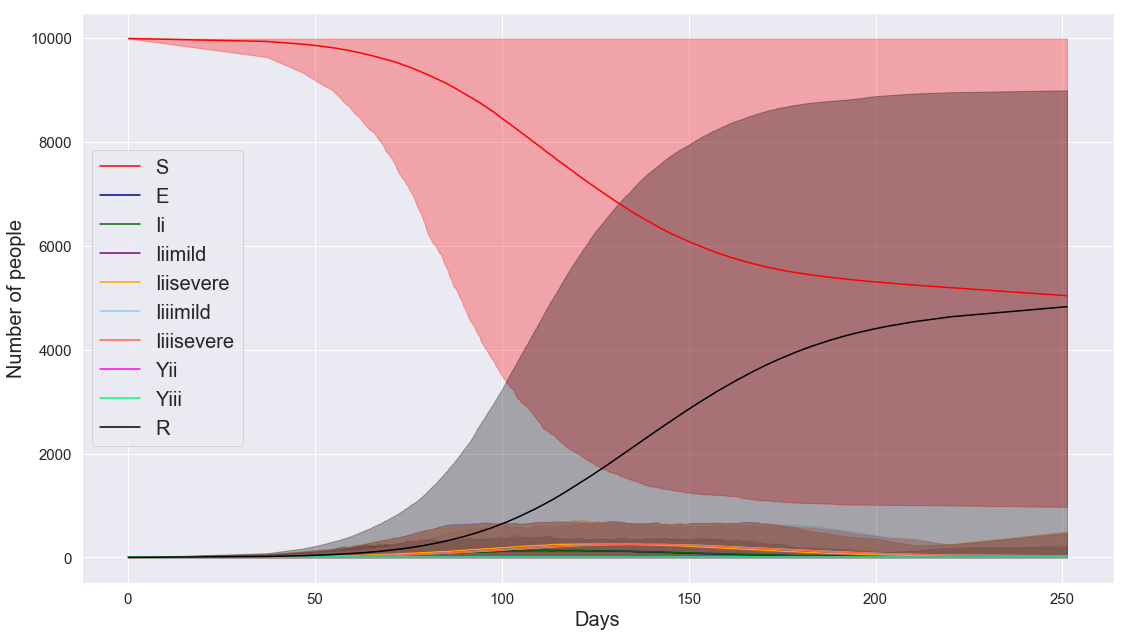

In [17]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Loop over all compartments of the model and plot on the same axes
for lab, col in zip(['S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R'],
       ['red','darkblue','darkgreen','purple','orange','skyblue','tomato','magenta','springgreen','black']):
    # Compute mean and credible limits
    df = merged_df[[lab+'_'+str(r) for r in range(0,nreals)]]
    df_mean = df.iloc[::plot_every_n, :].mean(axis=1)
    df_lowerCL = df.iloc[::plot_every_n, :].quantile(0.025,axis=1)
    df_upperCL = df.iloc[::plot_every_n, :].quantile(0.975,axis=1)
    # Plot the mean and credible limits in each case
    plt.plot(merged_df.index[::plot_every_n],df_mean.values,color=col,label=lab)
    plt.fill_between(merged_df.index[::plot_every_n],df_lowerCL.values,df_upperCL.values,color=col,alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_ylabel('Number of people',fontsize=20)
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()